In [1]:
import pandas as pd
import random
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import math
from operator import itemgetter
import matplotlib.pyplot as plt

# Data preparation

In [2]:
chickweight = pd.read_csv('chick_weight.csv')
chickweight = chickweight.drop(['Unnamed: 0'], axis=1)
chickweight_one_diet = chickweight[:][chickweight.Diet == 1]

In [3]:
def get_data_with_missing_values(data, portion_to_remove):
    """
    Randomly removing data to create data containing missing values
    portion_to_remove: fraction of data to be removed, eg. 0.1, 0.2, etc.
    """
    #     random.seed(10000)
    chickweight_with_missing_values = data.copy()
    Y = chickweight_with_missing_values["weight"]
    for i in range(len(Y)):
        if random.random()<portion_to_remove:
            Y[i] = 0  ##Randomly making few weights 0 to mimic missing data
    return chickweight_with_missing_values

In [4]:
def remove_missing_data_row(data):
    indices = data.index.values
    indices_to_remove = []
    for idx in indices:
        if data.loc[idx]["weight"] == 0:
            indices_to_remove.append(idx)
            
    data = data.drop(indices_to_remove)
    return data

In [5]:
def find_median(data):
    data = [x for x in data if x != 0]
    data.sort()
    if(len(data) % 2 != 0):
        mididx = math.floor(len(data)/2)
        median = data[mididx]
    else:
        mididx1 = math.floor(len(data)/2)
        mididx2 = math.floor(len(data)/2)-1
        median = (data[mididx1] + data[mididx2]) /2
    return median

def find_mean(data):
    count = 0
    for ele in data:
        if ele==0:
            continue
        else:
            count += 1
    return sum(data)/count
  
def replace(data, replacement):
    data_array = np.array(data)
    for idx in range(len(data_array)):
        if data_array[idx] ==0:
            data_array[idx] = replacement
        else:
            continue
    return data_array

def replace_missing_values(data_per_diet, replacement_parameter):
    new_df = pd.DataFrame(columns=["weight","Time","Chick","Diet"])
    for i in range(22):
            temp_time = data_per_diet.loc[data_per_diet['Time'] == i]
            count_row = temp_time.shape[0]
            if(count_row==0):
                continue
            else:
                if(replacement_parameter == "mean"):
                    replacement = find_mean(temp_time["weight"])
                elif(replacement_parameter == "median"):
                    replacement = find_median(temp_time["weight"])
                temp_time["weight"] = replace(temp_time["weight"], replacement)
                new_df = pd.concat([new_df, temp_time], ignore_index=True)
    return new_df

def replace_missing_values_all_diets(chickweight_with_missing_values, replacement_parameter):
    new_df = pd.DataFrame(columns=["weight","Time","Chick","Diet"])
    unique_diets = chickweight.Diet.unique()
    for diet in unique_diets:
        chickweight_one_diet = chickweight_with_missing_values[:][chickweight_with_missing_values.Diet == diet]
        chickweight_imputed_missing = replace_missing_values(chickweight_one_diet, replacement_parameter)
        new_df = pd.concat([new_df, chickweight_imputed_missing], ignore_index=True)
    return new_df

In [6]:
def replace_interpolation(data, replacement):
    r = 0
    data_array = np.array(data)
    for idx in range(len(data_array)):
        if data_array[idx] == 0:
            data_array[idx] = replacement[r]
            r += 1
        else:
            continue
    return data_array

def replacement_by_interpolation(data_per_diet):
    new_df = pd.DataFrame(columns=["weight","Time","Chick","Diet"])
    chicks = data_per_diet.Chick.unique()
    for chicknum in chicks:
        temp_chick = data_per_diet.loc[data_per_diet.Chick == chicknum]
        #get the known records (where weights are not missing)
        known = temp_chick.loc[temp_chick.weight != 0]
        #get the unknown records (where chick weight is missing)
        unknown = temp_chick.loc[temp_chick.weight == 0]
        x_known = known['Time'].values.tolist()
        y_known = known['weight'].values.tolist()
        x_unknown = unknown['Time'].values.tolist()
        #use interpolation to find the y_unknowns
        y_unknown = np.interp(x_unknown, x_known, y_known)
        replacement = y_unknown
        temp_chick["weight"] = replace_interpolation(temp_chick["weight"], replacement)
        new_df = pd.concat([new_df, temp_chick], ignore_index=True)
    return new_df

def replacement_by_interpolation_all_diets(chickweight_with_missing_values):
    new_df = pd.DataFrame(columns=["weight","Time","Chick","Diet"])
    unique_diets = chickweight.Diet.unique()
    for diet in unique_diets:
        chickweight_one_diet = chickweight_with_missing_values[:][chickweight_with_missing_values.Diet == diet]
        chickweight_imputed_missing = replacement_by_interpolation(chickweight_one_diet)
        new_df = pd.concat([new_df, chickweight_imputed_missing], ignore_index=True)
    return new_df

In [7]:
portions = [0.1, 0.2, 0.3, 0.4, 0.5]
missing_data = {}
removed_data = {}
mean_imputed_data = {}
median_imputed_data = {}
interpolation_imputed_data = {}

for portion in portions:
    missing_data[portion] = get_data_with_missing_values(chickweight, portion)
for portion in portions:
    removed_data[portion] = remove_missing_data_row(missing_data[portion])
    mean_imputed_data[portion] = replace_missing_values_all_diets(missing_data[portion], "mean")
    median_imputed_data[portion] = replace_missing_values_all_diets(missing_data[portion], "median")
    interpolation_imputed_data[portion] = replacement_by_interpolation_all_diets(missing_data[portion])    

# Effect of missing data on Confidence Interval

In [8]:
import math

def plot_confidence(df_this_diet, z_lower, z_upper):
    weight = 0
    time = 1
    # chickweight = chickweight.drop(['Unnamed: 0'], axis=1)
#     df_this_diet = chickweight[:][chickweight.Diet == 2]
    df_this_diet_values = df_this_diet.values
    X = np.array(df_this_diet_values[:,time], dtype=float)
    Y = np.array(df_this_diet_values[:,weight], dtype=float)

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.scatter(X, Y, alpha=0.5, color='orchid')
    fig.suptitle('Example Scatter Plot')
    fig.tight_layout(pad=2)
    ax.grid(True)
    z = np.polyfit(X, Y, 1)
    p = np.poly1d(z)
    xp = np.linspace(0, 22, 100)
    ax.plot(xp, p(xp),'-', color='darkorchid', linewidth=2)

    lower_p = np.poly1d(z_lower)
    lower = lower_p(xp)

    upper_p = np.poly1d(z_upper)
    upper = upper_p(xp)
    ax.fill_between(xp, lower, upper, color='#555555', alpha=0.4)
    plt.show(fig)

def get_slope_and_intercept(X, Y):
    z = np.polyfit(X, Y, 1)
    p = np.poly1d(z)
    xp = np.linspace(0, 22, 100)
    return (z[0], z[1])

def bootstrap(x):
    samp_x = []
    for i in range(len(x)):
        samp_x.append(random.choice(x))
    return samp_x

def bootstrap_data(data):
    new_df = pd.DataFrame(columns=["weight","Time","Chick","Diet"])
    for i in range(22):
        temp = data.loc[data['Time']==i]
        count_row = temp.shape[0]
        if(count_row==0):
            continue
        else:
            temp['weight'] = bootstrap(temp['weight'].values)
            new_df = pd.concat([new_df, temp], ignore_index=True)
    return new_df

def get_slopes_and_intercepts(chickweight):
    weight = 0
    time = 1
    uniqueDiets = chickweight.Diet.unique()
    num_shuffles = 100
    out_dict = {}
    for diet in uniqueDiets:
        output_this_diet = []
        for i in range(num_shuffles):
            df_this_diet = chickweight[:][chickweight.Diet == diet]
            bootstrapped_df = bootstrap_data(df_this_diet)
            df_this_diet_values = bootstrapped_df.values
            X = np.array(df_this_diet_values[:,time], dtype=float)
            Y = np.array(df_this_diet_values[:,weight], dtype=float)
            
            slope_and_intercept = get_slope_and_intercept(X, Y)
            output_this_diet.append(slope_and_intercept)
            
        out_dict[diet] = output_this_diet
    return out_dict

def get_confidence_interval(data):
    slope_out = get_slopes_and_intercepts(data)
    slope_confs = {}
    intercept_confs = {}
    conf_interval = 0.9
    for key, value in slope_out.items():
        slope_conf = []
        diet = key
        value.sort(key=itemgetter(0))
        tails = (1 - conf_interval) / 2
        lower_bound = int(math.ceil(100 * tails))
        upper_bound = int(math.floor(100 * (1 - tails)))
        slope_conf.append(value[lower_bound])
        slope_conf.append(value[upper_bound])
        slope_confs[key] = slope_conf
    
    return slope_confs

def get_new_conf_intervals(new_data):
    slope_confs_all_portions = {}
    result = pd.DataFrame(columns=["portion","diet","lower_bound","upper_bound"])
    for portion in portions:
        new_df = new_data[portion]
        slope_confs = get_confidence_interval(new_df)
        slope_confs_all_portions[portion] = slope_confs
        unique_diets = chickweight.Diet.unique()
        for diet in unique_diets:
            slope_conf = slope_confs[diet]
            result = result.append(
            {"portion": portion, 
             "diet": diet,
             "lower_bound": slope_conf[0][0], 
             "upper_bound": slope_conf[1][0]}, ignore_index=True)
        print("portion finished: ", portion)
    return result,slope_confs_all_portions

def plot_all_confidences(diet, portion, slope_confs_all_portions):
    slope_conf = slope_confs_all_portions[portion][diet]
    z_lower = [slope_conf[0][0], slope_conf[0][1]]
    z_upper = [slope_conf[1][0], slope_conf[1][1]]
    chickweight_one_diet = chickweight[:][chickweight.Diet == diet]
    plot_confidence(chickweight_one_diet, z_lower, z_upper)

In [10]:
portions = [0.1,0.2,0.3,0.4,0.5]

## Removing rows with missing values

portion finished:  0.1
portion finished:  0.2
portion finished:  0.3
portion finished:  0.4
portion finished:  0.5


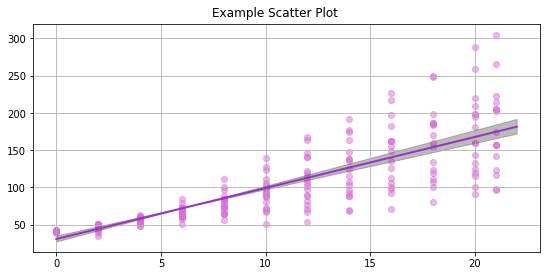

In [11]:
result_removed, slope_confs_removed = get_new_conf_intervals(removed_data)
plot_all_confidences(1, 0.1, slope_confs_removed)

## Impute missing data with mean

portion finished:  0.1
portion finished:  0.2
portion finished:  0.3
portion finished:  0.4
portion finished:  0.5


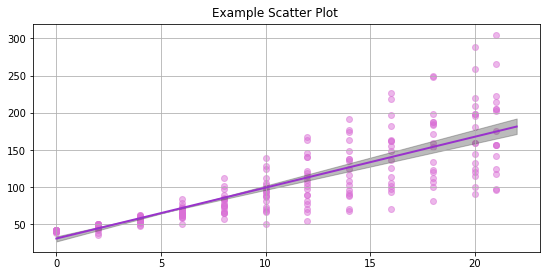

In [12]:
result_mean, slope_confs_mean = get_new_conf_intervals(mean_imputed_data)
plot_all_confidences(1, 0.1, slope_confs_mean)

## Impute missing data with median

portion finished:  0.1
portion finished:  0.2
portion finished:  0.3
portion finished:  0.4
portion finished:  0.5


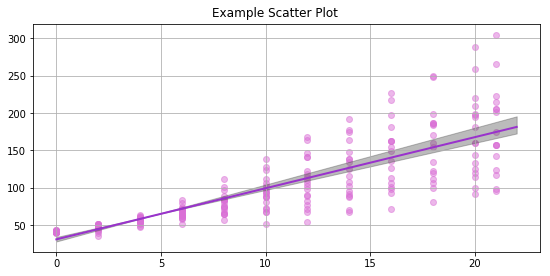

In [13]:
result_median, slope_confs_median = get_new_conf_intervals(median_imputed_data)
plot_all_confidences(1, 0.1, slope_confs_median)

## Impute missing data with linear interpolation

portion finished:  0.1
portion finished:  0.2
portion finished:  0.3
portion finished:  0.4
portion finished:  0.5


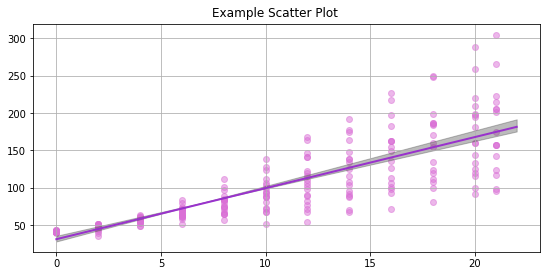

In [14]:
result_interpolation, slope_confs_interpolation = get_new_conf_intervals(interpolation_imputed_data)
plot_all_confidences(1, 0.1, slope_confs_interpolation)